Initialize environment and preprocess data

In [1]:
import sys
sys.path.append('../src')

In [2]:
import numpy as np
np.set_printoptions(precision=2, suppress=True)     # Set numpy to print only 2 decimal digits for neatness

import os
import configparser
import SimpleITK as sitk
import nibabel as nib
import shutil
import cv2
from matplotlib import pyplot as plt
from midetection.Utils import mri_config, utilities


In [3]:
config = configparser.RawConfigParser()
mri_path = mri_config.mri_path
corrected_img = mri_config.corrected_img
corrected_contour = mri_config.corrected_contour
processedImg_path = mri_config.processedImg_path
processedContour_path = mri_config.processedContour_path
all_paths = [corrected_img, corrected_contour, processedImg_path, processedContour_path]
# paths for reading images and contours
image_paths = []
contour_paths = []
# paths for saving center cropped and bias field corrected images and contours
save_paths = []
saveContour_paths = []

mri_dir = os.listdir(mri_path)

In [4]:
def get_myocardiumOnly(contour):
    # contours are labeled as follows: 0 - background, 1 - RV, 2 - myocardium, 2 - , 3 - LV cavity
    # get contour only for background and myocardium. change myocardium label to 255 (max brightness)
    thresholded_pixels = contour[:]
    cavity_indices = thresholded_pixels == 3
    thresholded_pixels[cavity_indices] = 0
    rv_indices = thresholded_pixels == 1
    thresholded_pixels[rv_indices] = 0
    myocardium_indices = thresholded_pixels == 2
    thresholded_pixels[myocardium_indices] = 1
    return thresholded_pixels

In [5]:
# center crop images to focus bias field correction to include only left ventricle as much as possible
def correctImages(image, mask, save_path, saveContour_path):
    input = sitk.ReadImage(image)
    image = sitk.Cast(input, sitk.sitkFloat32)
    width = image.GetWidth()
    height = image.GetHeight()
    depth = image.GetDepth()

    if width < 180:
        pad = int((180 - width) / 2)
        padding = np.zeros((depth, height, 180))
        padding[:depth, :height, pad:pad+width] = sitk.GetArrayFromImage(image)
        image = sitk.GetImageFromArray(padding)
    elif height < 180:
        pad = int((180 - height) / 2)
        padding = np.zeros((depth, 180, width))
        padding[:depth, pad:pad+height, :width] = sitk.GetArrayFromImage(image)
        image = sitk.GetImageFromArray(padding)
    
    center = (image.GetWidth() / 2, image.GetHeight() / 2)
    x = center[0] - 180/2
    y = center[1] - 180/2
    image = image[int(x):int(x+180), int(y):int(y+180), :]

    mask = sitk.ReadImage(mask, sitk.sitkUInt8)
    if width < 180:
        pad = int((180 - width) / 2)
        padding = np.zeros((depth, height, 180))
        padding[:depth, :height, pad:pad+width] = sitk.GetArrayFromImage(mask)
        mask = sitk.GetImageFromArray(padding)
    elif height < 180:
        pad = int((180 - height) / 2)
        padding = np.zeros((depth, 180, width))
        padding[:depth, pad:pad+height, :width] = sitk.GetArrayFromImage(mask)
        mask = sitk.GetImageFromArray(padding)
    mask = mask[int(x):int(x+180), int(y):int(y+180), :]
    mask = sitk.Cast(mask, sitk.sitkUInt8)
    # mask = sitk.OtsuThreshold(image, mask)
    corrector = sitk.N4BiasFieldCorrectionImageFilter()
    corrector.SetConvergenceThreshold = 0.001
    corrector.SetBiasFieldFullWidthAtHalfMaximum = 0.15
    corrector.SetMaximumNumberOfIterations = 50
    corrector.SetNumberOfControlPoints = 4
    corrector.SetNumberOfHistogramBins = 200
    corrector.SetSplineOrder = 3
    corrector.SetWienerFilterNoise = 0.1
    correctedImg = corrector.Execute(image, mask)

    sitk.WriteImage(correctedImg, save_path)
    sitk.WriteImage(mask, saveContour_path)

In [6]:
for path in all_paths:
    path_dir = os.listdir(path)
    for file in path_dir:
        try:
            shutil.rmtree(path + file)
        except OSError:
            os.remove(path + file)

NiftiImageIO (0x2cfe0c0): ../datasets/ACDC_dataset/diagnosis/training/patient079/patient079_frame01.nii.gz has unexpected scales in sform

NiftiImageIO (0x2cfe0c0): ../datasets/ACDC_dataset/diagnosis/training/patient079/patient079_frame01.nii.gz has unexpected scales in sform

NiftiImageIO (0x33663a0): ../datasets/ACDC_dataset/diagnosis/training/patient079/patient079_frame01_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x33663a0): ../datasets/ACDC_dataset/diagnosis/training/patient079/patient079_frame01_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x3330d70): ../datasets/ACDC_dataset/diagnosis/training/patient079/patient079_frame11.nii.gz has unexpected scales in sform

NiftiImageIO (0x3330d70): ../datasets/ACDC_dataset/diagnosis/training/patient079/patient079_frame11.nii.gz has unexpected scales in sform

NiftiImageIO (0x33cf0f0): ../datasets/ACDC_dataset/diagnosis/training/patient079/patient079_frame11_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x33

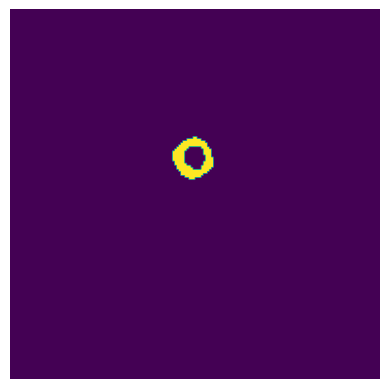

In [7]:
# extract ED and ES images then perform bias correction and center cropping
for caseNum in mri_dir:
    if (os.path.splitext(caseNum)[1] != ".cfg"):
        configFilePath = mri_path + caseNum + "/Info.cfg"
        with open(configFilePath, 'r') as f:
            config_string = '[dummy_section]\n' + f.read()
        config = configparser.ConfigParser()
        config.read_string(config_string)
        group = config.get("dummy_section", "Group")
        ed = config.get("dummy_section", "ED")
        es = config.get("dummy_section", "ES")

        if group == "NOR" or group == "MINF":
            contour_paths.append(mri_path + caseNum + "/" + caseNum + "_frame0" + str(ed) + "_gt.nii.gz")
            image_paths.append(mri_path + caseNum + "/" + caseNum + "_frame0" + str(ed) + ".nii.gz")
            save_paths.append(corrected_img + "/" + caseNum + "_ed.nii.gz")
            saveContour_paths.append(corrected_contour + "/" + caseNum + "_ed.nii.gz")
            if int(es) < 10:
                contour_paths.append(mri_path + caseNum + "/" + caseNum + "_frame0" + str(es) + "_gt.nii.gz")
                image_paths.append(mri_path + caseNum + "/" + caseNum + "_frame0" + str(es) + ".nii.gz")
            else:
                contour_paths.append(mri_path + caseNum + "/" + caseNum + "_frame" + str(es) + "_gt.nii.gz")
                image_paths.append(mri_path + caseNum + "/" + caseNum + "_frame" + str(es) + ".nii.gz")
            save_paths.append(corrected_img + "/" + caseNum + "_es.nii.gz")
            saveContour_paths.append(corrected_contour + "/" + caseNum + "_es.nii.gz")
            correctImages(image_paths[-2], contour_paths[-2], save_paths[-2], saveContour_paths[-2])
            correctImages(image_paths[-1], contour_paths[-1], save_paths[-1], saveContour_paths[-1])

            corrImg_ed = nib.load(save_paths[-2]).get_fdata()
            contour_ed = nib.load(saveContour_paths[-2]).get_fdata()      
            corrImg_es = nib.load(save_paths[-1]).get_fdata()
            contour_es = nib.load(saveContour_paths[-1]).get_fdata()

            contour_ed = get_myocardiumOnly(contour_ed)
            contour_es = get_myocardiumOnly(contour_es)        

            numSlices = corrImg_ed.shape[2]
            midSlice = int(np.ceil(numSlices/2))

            def make_dir_save_png(foldername, filename, plt):
                utilities.create_dir(foldername)
                filepath = os.path.join(foldername, filename)
                plt.savefig(filepath)

            
            for i in range(2,numSlices-1):
                if i >= 0 and i < 10:
                    prefix = "0"
                else:
                    prefix = ""
                plt.imshow(corrImg_ed[:,:,i])
                plt.axis('off')
                make_dir_save_png(processedImg_path, "{}_{}{}_ed.png".format(caseNum, prefix, str(i)), plt)
                plt.imshow(contour_ed[:,:,i])
                plt.axis('off')
                make_dir_save_png(processedContour_path, "{}_{}{}_ed.png".format(caseNum, prefix, str(i)), plt)
                plt.imshow(corrImg_es[:,:,i])
                plt.axis('off')
                make_dir_save_png(processedImg_path, "{}_{}{}_es.png".format(caseNum, prefix, str(i)), plt)
                plt.imshow(contour_es[:,:,i])
                plt.axis('off')
                make_dir_save_png(processedContour_path, "{}_{}{}_es.png".format(caseNum, prefix, str(i)), plt)

In [8]:
# define paths for training and testing sets
import random
from midetection.lib.siamese_net.siamese_net.config import MRIPaths

partial_paths = mri_config.partial_paths

images_dir = os.listdir(processedImg_path)
random.shuffle(images_dir)

utilities.createFolderFromPaths(partial_paths)
utilities.removeFilesFromPaths(partial_paths)
utilities.removeFile(MRIPaths.training_csv)
utilities.removeFile(MRIPaths.validating_csv)
utilities.removeFile(MRIPaths.testing_csv)

In [9]:
# center crop to remove white sides then resize to 224x224
# convert groundtruth to black and white
def convert_image(path, isInput):
    imcolor = cv2.imread(path)
    if isInput == False:
        imcolor = cv2.cvtColor(imcolor, cv2.COLOR_BGRA2GRAY)
        thresholded_pixels = imcolor[:]
        myocardium_indices = thresholded_pixels > 127
        thresholded_pixels[myocardium_indices] = 255
        background_indices = thresholded_pixels <= 127
        thresholded_pixels[background_indices] = 0
    else:
        imcolor = cv2.cvtColor(imcolor, cv2.COLOR_BGRA2BGR)
    center = (imcolor.shape[0] / 2, imcolor.shape[1] / 2)
    x = center[1] - 204/2
    y = center[0] - 204/2
    imcolor = imcolor[int(y):int(y+204), int(x):int(x+204)]
    pad = int((224 - 204) / 2)
    if isInput == True:
        padding = np.zeros((224,224,3))
        padding[pad:pad+204, pad:pad+204, :3]  = imcolor
    else:
        padding = np.zeros((224,224))
        padding[pad:pad+204, pad:pad+204]  = imcolor
    imcolor = padding
    # imcolor = cv2.resize(imcolor, (224,224), interpolation = cv2.INTER_AREA)
    cv2.imwrite(path, imcolor)

In [10]:
def transfer_images(count, split, image, validating=False):
    from csv import writer
    filename = image.split("_e")[0]

    path = processedImg_path + filename
    test_path = partial_paths[2]
    train_path = partial_paths[0]
    valid_path = partial_paths[4]

    contourpath = processedContour_path + filename
    contourtest_path = partial_paths[3]
    contourtrain_path = partial_paths[1]
    contourvalid_path = partial_paths[5]

    configFilePath = mri_path + filename.split("_")[0] + "/Info.cfg"
    with open(configFilePath, 'r') as f:
        config_string = '[dummy_section]\n' + f.read()
    config = configparser.ConfigParser()
    config.read_string(config_string)
    group = config.get("dummy_section", "Group")
    label = 1 if (group == "MINF") else 0

    if validating == False:
        if count < split:
            shutil.copy(path + "_ed.png", test_path)
            convert_image(test_path + filename + "_ed.png", isInput=True)
            shutil.copy(contourpath + "_ed.png", contourtest_path)
            convert_image(contourtest_path + filename + "_ed.png", isInput=False)
            shutil.copy(path + "_es.png",test_path)
            convert_image(test_path + filename + "_es.png", isInput=True)
            shutil.copy(contourpath + "_es.png", contourtest_path)
            convert_image(contourtest_path + filename + "_es.png", isInput=False)

            with open(MRIPaths.testing_csv,'a+') as fd:
                writer_object = writer(fd)
                writer_object.writerow([filename + "_ed.png",filename + "_es.png",label])
                fd.close()
        else:
            shutil.copy(path + "_ed.png", train_path)
            convert_image(train_path + filename + "_ed.png", isInput=True)
            shutil.copy(contourpath + "_ed.png",contourtrain_path)
            convert_image(contourtrain_path + filename + "_ed.png", isInput=False)
            shutil.copy(path + "_es.png", train_path)
            convert_image(train_path + filename + "_es.png", isInput=True)
            shutil.copy(contourpath + "_es.png", contourtrain_path)
            convert_image(contourtrain_path + filename + "_es.png", isInput=False)
    else:    
        if count < split:
            shutil.move(train_path + filename + "_ed.png", valid_path)
            shutil.move(contourtrain_path + filename + "_ed.png", contourvalid_path)
            shutil.move(train_path + filename + "_es.png", valid_path)
            shutil.move(contourtrain_path + filename + "_es.png", contourvalid_path)

            with open(MRIPaths.validating_csv,'a+') as fd:
                writer_object = writer(fd)
                writer_object.writerow([filename + "_ed.png",filename + "_es.png",label])
                fd.close()
        else:
            with open(MRIPaths.training_csv','a+') as fd:
                writer_object = writer(fd)
                writer_object.writerow([filename + "_ed.png",filename + "_es.png",label])
                fd.close()

In [11]:
# split images into training and testing sets
test_size = 0.25

num_input = len(images_dir)
indices = list(range(num_input))
split = int(np.ceil(test_size * num_input))
# print("Split at index '%i'." % split)
print(str(split) + " images for testing and " + str(num_input-split) + " for training.")

# copy some into folder for testing and training
count = 0
for image in images_dir:
    if (image not in os.listdir(partial_paths[0])) and (image not in os.listdir(partial_paths[2])):
        transfer_images(count, split, image, validating=False)
        count += 2

112 images for testing and 334 for training.


In [12]:
# split training data into training and validating sets
train_dir = os.listdir(partial_paths[0])
random.shuffle(train_dir)

valid_size = 0.15

num_training = len(train_dir)
indices = list(range(num_training))
split = int(np.floor(valid_size * num_training))
# print("Split at index '%i'." % split)
print(str(split) + " images for validating and " + str(num_training-split) + " for training.")

# copy some into folder for validating set
count = 0
for image in train_dir:
    instance = os.path.splitext(image)[0].split("_", 2)[2]
    if image not in os.listdir(partial_paths[4]) and (instance != "es"):
        transfer_images(count, split, image, validating=True)
        count += 2

50 images for validating and 284 for training.


Train segmentation model and evaluate

Successfully created the logger directory ./logger
selected device is  cuda:0
Setting model parameters
Creating folders for every data
Training ongoing...


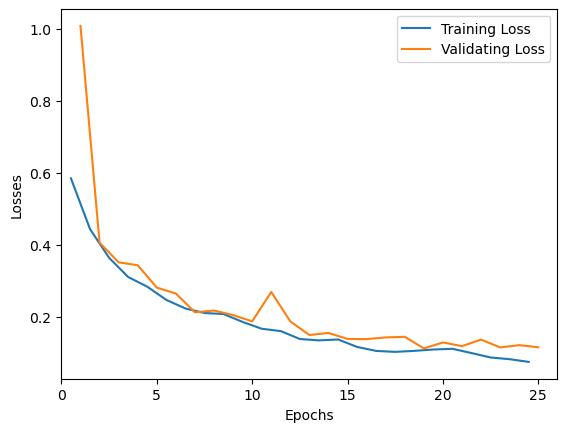

Testing the model...
Dice Score : 0.14680658559582696


In [13]:
from midetection.lib.UNet.pytorch_run import run_model

test_data_paths = [partial_paths[2] + sorted(os.listdir(partial_paths[2]))[0], partial_paths[3] + sorted(os.listdir(partial_paths[3]))[0]]

run_model(batch_size=4, epoch=25, base_paths=partial_paths + test_data_paths)

In [14]:
## If needed, cleanup mask predictions here. Uncomment below

from midetection.lib.UNet.pytorch_run import cleanup_Predictions

cleanup_Predictions("./model/training_masks/", 20)
cleanup_Predictions("./model/validating_masks/", 20)

Quantify wall motion and mycardial thickening

In [15]:
from midetection.quantify.quantify_mri import get_centerAndThicknessOfAllSegments, measure_wallMotion, measure_myocardialThickening

centers, thickness, image_index = get_centerAndThicknessOfAllSegments()
wallMotion = measure_wallMotion(centers, image_index)
myocardialThickening = measure_myocardialThickening(thickness, image_index)

Center and thickness of all segments acquired.
Wall motion measured for all segments.
Myocardial thickening measured for all segments.


Train and test MI classifier

2024-05-11 22:46:25.794170: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-11 22:46:26.687020: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-11 22:46:28.585417: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Training the model...


/home/laballais/miniconda3/envs/mi-detection/lib/python3.9/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Testing the model...


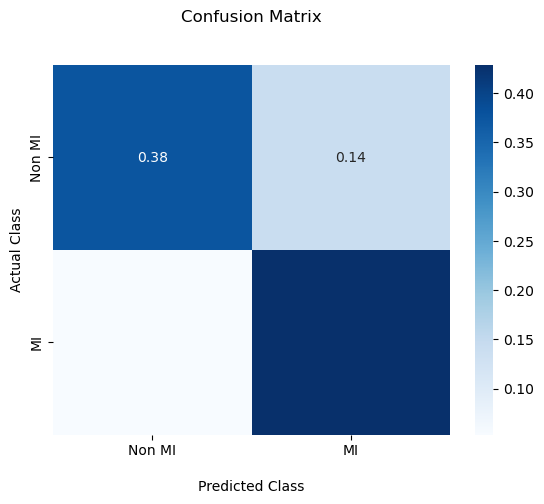


Accuracy: 80.35714285714286 %
Sensitivity: 74.99999765625009 %
Precision: 88.88888559670794 %
Specificity: 87.49999635416683 %


In [16]:
# LR=1e-4 epoch=400 batch_size=2 with early stopping
from midetection.lib.siamese_net.siamese_net.train_bce import train_model, test_model
from midetection.lib.siamese_net.siamese_net.utils import normalize_data1

wallMotion = normalize_data1(wallMotion)
myocardialThickening = normalize_data1(myocardialThickening)

model, recall, prec, loss, validLoss, counter = train_model(wallMotion, myocardialThickening, data="MRI")
accuracy, sensitivity, precision, specificity, prediction, groundtruth = test_model(wallMotion, myocardialThickening, data="MRI", net = model)